<a href="https://colab.research.google.com/github/satfail/AI-Reading-Materials/blob/master/BAJOGRADO_CheckPoint_Xception_Articulo_CAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargamos las imágenes el Drive e importamos Tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive/CelulasArticulo"

#raiz
PATH = "/content/drive/My Drive"

#ipunt

INPATH = PATH + '/CelulasArticulo'

OUTPUT = PATH + '/CelulasFiltradas_Ascus'

#checkpoints

CPATH = PATH + '/checkpointsCelulas'

!ls "/content/drive/MyDrive/checkpointsCelulas"

entrenamiento  test
fulldata  testGanAltoGrado     ultimo	  ultimoRev_SEED_29259
test	  testGanAltoGradoRev  ultimoRev


In [ ]:
!pip uninstall tensorflow -y
!pip install  tensorflow==2.4.1

     |██████████████████████████████▊ | 378.4MB 22kB/s eta 0:11:36
ERROR: THESE PACKAGES DO NOT MATCH THE HASHES FROM THE REQUIREMENTS FILE. If you have updated the package versions, please update the hashes. Otherwise, examine the package contents carefully; someone may have tampered with them.
    tensorflow==2.4.1 from https://files.pythonhosted.org/packages/70/dc/e8c5e7983866fa4ef3fd619faa35f660b95b01a2ab62b3884f038ccab542/tensorflow-2.4.1-cp37-cp37m-manylinux2010_x86_64.whl#sha256=22723b8e1fa83b34f56c349b16a57aaff913b404451fcf70981f2b1d6e0c64fc:
        Expected sha256 22723b8e1fa83b34f56c349b16a57aaff913b404451fcf70981f2b1d6e0c64fc
             Got        490cf142af97e9173f7d0ef2929a6cfd2c262feef10a5052ffd5f4c88d206216



In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import AveragePooling2D

print(tf.__version__)

2.5.0


# Cargamos el set de Datos y Preprocesado
*   Defininmos el ImageDataGenerator para aumentar el dataset, con zoom, flip,rotación..
*  Hacemos plot para compronbar como quedan las imágenes generadas

In [ ]:
import pathlib
data_train = pathlib.Path(INPATH + '/entrenamiento/') 
count = len(list(data_train.glob('*/*.tiff')))
print('Entrenamiento : ' + str(count))
data_test = pathlib.Path(INPATH + '/test/') 
count = len(list(data_test.glob('*/*.png')))
print('Test : ' + str(count))
data_train

Entrenamiento : 1743
Test : 2000


PosixPath('/content/drive/My Drive/CelulasArticulo/entrenamiento')

In [ ]:
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_height = 224
img_width = 224

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1) # set validation split

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    data_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
    subset='training',
    seed=25) # set as training data

validation_generator = train_datagen.flow_from_directory(
    data_train, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
    subset='validation',
    seed=25) # set as validation data

test_generator = test_datagen.flow_from_directory(INPATH + '/test',
                                                target_size=(224, 224),
                                                batch_size=1,
                                                shuffle=False,
                                             class_mode='categorical')



/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 1571 images belonging to 4 classes.
Found 172 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


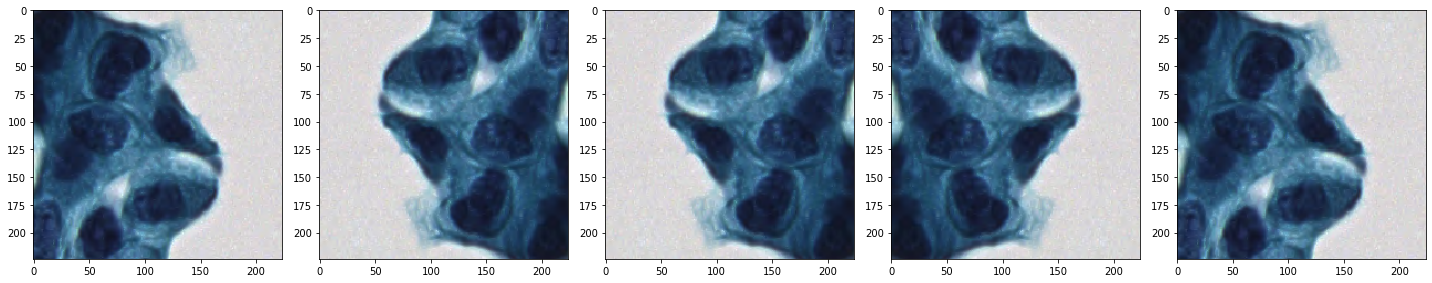

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
    
augmented_images = [train_generator[1][0][0] for i in range(5)]
plotImages(augmented_images)

# Creamos el modelo

 

*   Modelo Secuencial, 32 filtros de entrada.
*   strides = número de pasos que se mueve el filtro   y padding= añadimos 0 para generar salida igual a entrada
*   BatchNormalization() Normaliza capas de entrada 
*   Dropout Eliminar sobreajuste, desactivamos algunas conjuntos de neuronas

In [ ]:
from tensorflow.keras.layers import Dropout, BatchNormalization
#from keras.applications.xception import Xception
from tensorflow.python.keras.applications.xception import Xception

baseModel = Xception(weights="imagenet", include_top=False,
	input_shape =  (224, 224, 3) )

## Fine Tuning

El ajuste está en la cabeza del modelo, donde especificamos las clases que vamos a tener que predecir

In [ ]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(4, activation="softmax")(headModel)

In [ ]:
#from keras.models import Model
from tensorflow.python.keras.models import Model
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [ ]:
print("Number of layers in the base model: ", len(model.layers))

Number of layers in the base model:  137


## CUIDADO! 

En este ejemplo:

### Congelamos las 40 primeras capas, ahí estarían las formas más básicas en el modelo aprendidas, el resto de capas las entrenamos para que se ajuste al problema


In [ ]:
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

print(steps_per_epoch)
print(validation_steps)

49
5


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import os

earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
optimizer = tf.keras.optimizers.Adam (lr=0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

checkpoint_filepath = CPATH + '/testGanAltoGrado/'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    save_freq = 15,
    save_best_only=False)

# Cargar check
model.load_weights(checkpoint_filepath)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## OPCIONAL: ENTRENAR EL MODELO

In [ ]:
history = model.fit(train_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          validation_data=validation_generator,
          validation_steps=validation_steps,
          callbacks=[reduce_lr,model_checkpoint_callback,earlystopping])

Epoch 1/100
49/49 [==============================] - 529s 10s/step - loss: 0.0520 - accuracy: 0.9855 - val_loss: 1.5660 - val_accuracy: 0.6062
Epoch 2/100
49/49 [==============================] - 33s 675ms/step - loss: 0.2768 - accuracy: 0.9127 - val_loss: 2.4756 - val_accuracy: 0.6687
Epoch 3/100
49/49 [==============================] - 32s 661ms/step - loss: 0.2604 - accuracy: 0.9057 - val_loss: 4.6821 - val_accuracy: 0.5375
Epoch 4/100
49/49 [==============================] - 34s 703ms/step - loss: 0.1888 - accuracy: 0.9386 - val_loss: 1.8602 - val_accuracy: 0.5312
Epoch 5/100
49/49 [==============================] - 34s 691ms/step - loss: 0.2055 - accuracy: 0.9271 - val_loss: 0.8702 - val_accuracy: 0.6812
Epoch 6/100
49/49 [==============================] - 34s 704ms/step - loss: 0.1207 - accuracy: 0.9598 - val_loss: 1.9422 - val_accuracy: 0.5875
Epoch 7/100
49/49 [==============================] - 34s 702ms/step - loss: 0.1458 - accuracy: 0.9530 - val_loss: 1.4852 - val_accuracy: 

In [ ]:
model.evaluate(x=validation_generator,
steps=validation_steps)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7ff1d3c08950>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7ff1d3c08950>. Note that func

[1.5269725322723389, 0.706250011920929]

In [ ]:
test_predict = model.predict(test_generator, steps = test_generator.n // 1, verbose =1)

2000/2000 [==============================] - 538s 269ms/step


In [ ]:
test_predict.shape

(2000, 4)

In [ ]:
test_predict

array([[2.4680959e-01, 7.3147911e-01, 2.1458253e-02, 2.5310574e-04],
       [1.6005428e-01, 2.0364761e-02, 8.0460513e-01, 1.4975800e-02],
       [7.5532950e-02, 2.0168877e-01, 5.2365947e-01, 1.9911884e-01],
       ...,
       [1.7489849e-02, 4.0752464e-03, 1.8962964e-03, 9.7653860e-01],
       [2.5671711e-03, 1.1948289e-02, 9.8523730e-01, 2.4722604e-04],
       [8.8258326e-01, 4.4757072e-02, 7.0718370e-02, 1.9413562e-03]],
      dtype=float32)

In [ ]:
predict = []

for i in test_predict:
  predict.append(int(np.argmax(i)))

predict = np.asarray(predict)

In [ ]:
np.asarray(predict)


array([1, 2, 2, ..., 3, 2, 0])

In [ ]:
# Obtenemos la tasa de acierto del modelo
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_generator.classes, np.asarray(predict))
accuracy

0.646

In [ ]:
test_generator.class_indices

{'altogrado': 0, 'ascus (1)': 1, 'bajogrado': 2, 'benigna': 3}

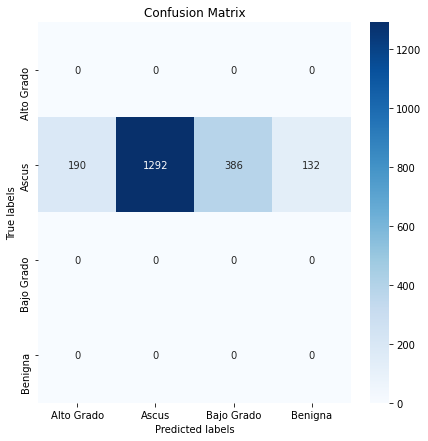

In [ ]:
# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_generator.classes, predict)
plt.figure(figsize = (7,7))
ax= plt.subplot()
sns.heatmap(cm, annot=True ,fmt="d",cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Alto Grado', 'Ascus', 'Bajo Grado', 'Benigna']); ax.yaxis.set_ticklabels(['Alto Grado', 'Ascus', 'Bajo Grado', 'Benigna']);

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

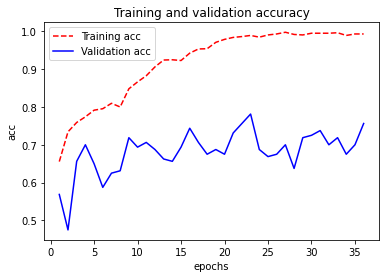

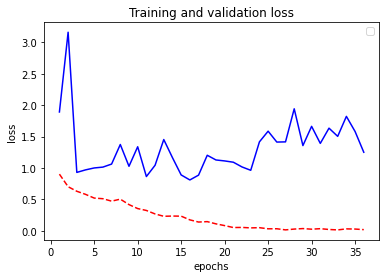

<Figure size 432x288 with 0 Axes>

In [ ]:

acc      = history.history['accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs    = range(1,len(acc)+1,1) # obtener número de epochs

plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()


plt.plot  ( epochs,     loss, 'r--' )
plt.plot  ( epochs, val_loss ,  'b' )
plt.title ('Training and validation loss'   )
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend()
plt.figure()

# Filtrado de Imágenes

In [ ]:
array_predict_labels = np.asarray(predict)


predict

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
import shutil, os

directory = INPATH + '/test/ascus (1)'

for label, filename in zip( predict, os.listdir(directory) ):
    if label == 0:
        print('{} AltoGrado, en ruta {}'.format(label,os.path.join(directory, filename)))
        shutil.copyfile(os.path.join(directory, filename), os.path.join(OUTPUT + '/altogrado', filename))
    elif label == 1:
        print('{} Ascus, en ruta {}'.format(label,os.path.join(directory, filename)))
        shutil.copyfile(os.path.join(directory, filename), os.path.join(OUTPUT + '/ascus', filename))
    elif label == 2:
        print('{} Bajo Grado, en ruta {}'.format(label,os.path.join(directory, filename)))
        shutil.copyfile(os.path.join(directory, filename), os.path.join(OUTPUT + '/bajogrado', filename))
    elif label == 3:
        print('{} Benigna, en ruta {}'.format(label,os.path.join(directory, filename)))
        shutil.copyfile(os.path.join(directory, filename), os.path.join(OUTPUT + '/benigna', filename))
    else:
      continue
    

1 Ascus, en ruta /content/drive/My Drive/CelulasArticulo/test/ascus (1)/seed5086.png
2 Bajo Grado, en ruta /content/drive/My Drive/CelulasArticulo/test/ascus (1)/seed3875537.png
2 Bajo Grado, en ruta /content/drive/My Drive/CelulasArticulo/test/ascus (1)/seed5306.png
1 Ascus, en ruta /content/drive/My Drive/CelulasArticulo/test/ascus (1)/seed3874976.png
1 Ascus, en ruta /content/drive/My Drive/CelulasArticulo/test/ascus (1)/seed3875663.png
1 Ascus, en ruta /content/drive/My Drive/CelulasArticulo/test/ascus (1)/seed5606.png
2 Bajo Grado, en ruta /content/drive/My Drive/CelulasArticulo/test/ascus (1)/seed5600.png
1 Ascus, en ruta /content/drive/My Drive/CelulasArticulo/test/ascus (1)/seed3874702.png
1 Ascus, en ruta /content/drive/My Drive/CelulasArticulo/test/ascus (1)/seed5277.png
1 Ascus, en ruta /content/drive/My Drive/CelulasArticulo/test/ascus (1)/seed3875996.png
1 Ascus, en ruta /content/drive/My Drive/CelulasArticulo/test/ascus (1)/seed3874885.png
1 Ascus, en ruta /content/drive/

'/content/drive/My Drive/CelulasFiltradas/test'